In [ ]:
# Modules import
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import tkinter
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

##Data given in *thrust_data_2*

In [ ]:
T = 101
delta_t = 0.1
alpha = 1
m = 1
g = 10
p_max = 5
u_max = None

theta_1 = 50*np.pi/180
theta_2 = 120*np.pi/180

J = np.array([30,50,70,100])
w = np.array([[-2,  2],
              [ 3,  3],
              [-4, -1],
              [ 2, -4]])

# I. Optimization functions

## a. Secondary functions

### Declaration of variables

The function `variables_init` initializes and returns three optimization variables in the format of matrices of given dimensions:
* `thrust_force`
* `positions`
* `velocity`

Input parameters:
* `T` = the number of time steps
* `dim` = the dimension in which the drone moves
* `motor_count` = the number of motors in the drone

In [ ]:
# Variable matrices
def variables_init(T,dim=2,motor_count=2):
  return  (cp.Variable((motor_count, T-1)),
          cp.Variable((dim, T)),
          cp.Variable((dim, T)))

### Force matrix

Function `angles` gets and converts the angles (*theta* and *phi*) and returns a tuple containing:
* a list of theta values in radians
* a list of phi values in radians

Input parameters:

* `tc` = number of motors
* `dim` = the dimension
* `radians` = `True` if the angles are in radians, `False` otherwise
* `thetas` = a list of *theta* angles
* `phis` = a list of *phi* angles

In [ ]:
def angles(tc,**kwargs):

  # converts degrees to radians
  fn = lambda x: x*np.pi/180

  dim = kwargs.get("dim",2)
  radians = kwargs.get("radians",True)
  values = ()

  # assign values: 2D - only thetas, 3D - also phis
  # number of motors can be changed
  for angle, d in ("theta",1),("phi",2):
    arcs = kwargs.get(angle+"s")
    default = None if d < dim else 0
    if arcs is None:
      arcs = []
      for i in range(tc):
        arc = kwargs.get(f'{angle}_{i+1}', default)
        assert arc is not None, f'{angle}_{i+1} not defined'
        arcs.append(arc if radians else fn(arc))
    else:
      assert tc == len(arcs), angle + " count does not equal to motor count"
      if not radians:
        arcs = [fn(arc) for arc in arcs]
    values += arcs,
  return values


Function `forces_relations` calculates the resultant forces based on thrust forces, gravity and returns a matrix of resultant forces.

$
in \ R^{2}: \
f_k =
\begin{bmatrix}
f_k^{(1)} \\
f_k^{(2)}
\end{bmatrix}
=
\begin{bmatrix}
\cos(\theta_1) u_k^{(1)} + \cos(\theta_2) u_k^{(2)} \\
\sin(\theta_1) u_k^{(1)} + \sin(\theta_2) u_k^{(2)} - mg
\end{bmatrix}
$

$
in \ R^{3}: \
\
f_k =
\begin{bmatrix}
f_k^{(1)} \\
f_k^{(2)} \\
f_k^{(3)}
\end{bmatrix}
=
\begin{bmatrix}
\sum_{i=1}^{4} u_i \cos(\phi_i) \sin(\theta_i) \\
\sum_{i=1}^{4} u_i \cos(\phi_i) \cos(\theta_i) \\
\sum_{i=1}^{4} \left( u_i \sin(\phi_i) \right) - mg
\end{bmatrix}
\
$



Input parameters:

* `thrust_force` = ndarray of thrust forces
* `g` = gravitational acceleration
* `dim` = dimension
* `m` = weight of the drone
* `thetas` = a list of theta angles
* `phis` = a list of phi angles / a list of zeroes in 2D

In [ ]:
def forces_relations(thrust_force,**kwargs):

  g = kwargs.get('g',10)
  dim = kwargs.get('dim',2)
  m = kwargs.get('m')
  assert m is not None, "m must be defined"
  tc = thrust_force.shape[0]
  thetas = kwargs.get("thetas")
  phis = kwargs.get("phis")

  dim_f = [[np.cos,np.cos],[np.cos,np.sin],[np.sin,lambda x: 1]]
  forces = []
  for i in range(dim):
    f1, f2 = dim_f[i]
    rel = f1(phis[0])*f2(thetas[0]) * thrust_force[0,:]
    for motor in range(1,tc):
        rel += f1(phis[motor])*f2(thetas[motor]) * thrust_force[motor,:]
    if i == dim-1:
        rel -= m * g
    forces.append(rel)

  return cp.vstack(forces)

### Constraints

The function `constraints_full` sets up constraints for the optimization problem and returns a list of constraints.

Constraints for the 2D case:

$
\begin{align*}
& 1. \ v_{k+1} = e^{α\Delta t}v_{k} + \frac{f_{k}}{m}\Delta t
\\
& 2. \ x_{k+1} = x_{k}+v_{k} \Delta t
\\
& 3. \ \forall j \in J \subset \{0, 1, 2, \dots, T\}, \, x_j = w_j \\
& 4. \ \forall i \in \{0, 1, 2, \dots, T\}, \, (-x_i \geq -x_{\max} \wedge x_i \geq -x_{\max}) ⇔\|x_k\|_\infty \leq x_{\max} \\
& 5. \ \forall i \in \{0, 1, 2, \dots, T\}, \, u_i^{(1)}, u_i^{(2)} \geq 0\\
& 6. \ \forall i \in \{0, 1, 2, \dots, T\}, \, u_i^{(1)}, u_i^{(2)} \leq u_{\max}
\end{align*}
$

In [ ]:
def constraints_full(position, velocity, thrust_force, forces, **kwargs):
  dt = kwargs.get('dt', 0.1)
  alpha = kwargs.get('alpha', 1)
  J = kwargs.get('J')
  w = kwargs.get('w')
  u_max = kwargs.get('u_max')
  p_max = kwargs.get('p_max')
  m = kwargs.get('m')
  vel = kwargs.get('vel',False)
  dim, T = position.shape
  tc = thrust_force.shape[0]

  # initial conditions: x_0 = 0, v_0 = 0
  constraints = [position[0:dim, 0] == 0,velocity[0:dim, 0] == 0]

  for t in range(T - 1):
    # 1. constraint
    constraints.append(
          velocity[:, t + 1] == np.exp(-alpha * dt) * velocity[:, t] + (forces[:, t] / m) * dt)

    # 2. constraint
    constraints.append(position[:, t + 1] == position[:, t] + dt * velocity[:, t])

  # 3. constraint
  for index in range(len(J)):
    j = J[index]
    constraints.append(position[:,j]==w[index,:])

  # 4. constraint
  constraints.append(cp.abs(position) <= p_max)

  # 5. constraint
  constraints.append(thrust_force >= 0)
  # 6. constraint
  if u_max:
    constraints.append(thrust_force <= u_max)

  return constraints

## b. Main function

Function `drone` sets up and solves an optimization problem for drone control. The goal is to minimize fuel consumption with given constraints. The function returns:

* positions of the drone `position`
* thrust forces `thrust_force`
* optimal fuel consumption `result`

In [ ]:
def drone(**kwargs):
  T = kwargs.get('T')
  dim = kwargs.get('dim',2)
  motor_count = kwargs.get('motor_count',2)
  g = kwargs.get('g',10)
  alpha = kwargs.get('alpha')
  dt = kwargs.get('dt')
  m = kwargs.get("m")
  p_max = kwargs.get("p_max")
  u_max = kwargs.get('u_max')
  J = kwargs.get("J")
  w = kwargs.get("w")
  theta0 = kwargs.get("thetas")
  phi0 = kwargs.get("phis", [])
  assert T is not None, "T must be defined"
  assert alpha is not None, "alpha must be defined"
  assert m is not None, "m must be defined"
  assert m > 0, "weight must be positive"
  assert p_max is not None, "p_max must be defined"
  assert J is not None, "J must be defined"
  assert w is not None, "w must be defined"

  assert len(J) == len(w), "J and w is not same length!"
  assert J.shape != (0,) and max(J) < T and min(J) >= 0,"J is\
  not correct"
  assert w.shape[1] == dim, "Dimension of required position\
   should match with current dimension"

  # getting optimization variables
  thrust_force, position, velocity = variables_init(T,dim,motor_count)

  # getting the angles of the motors
  thetas, phis = angles(motor_count,**kwargs)

  # getting the resultant forces
  forces = forces_relations(thrust_force, g=g, dim=dim, m=m,
                            thetas=thetas, phis=phis)

  # setting up the optimization problem
  objective = cp.Minimize(cp.sum(thrust_force))
  constraints = constraints_full(position,velocity,thrust_force,forces,
                                 dt = dt,
                                 alpha = alpha,
                                 u_max = u_max,
                                 p_max = p_max,
                                 m = m,
                                 J = J,
                                 w = w,
                                 vel = kwargs.get("vel",False)
                                 )

  # solving the optimization problem
  prob = cp.Problem(objective, constraints)

  result = prob.solve(verbose=kwargs.get("verbose",False))
  print("Solver Status:", prob.status)
  print("Optimálne riadenia je možné so spotrebou:", round(result,2), "jednotiek paliva.")

  return position.value,thrust_force.value,result

# II. Visualization functions

## 2D visualization

The function `plot_trajectory` plots the drone's trajectory in 2D using python library `matplotlib.pyplot`.

Input parameters of the function:

* `positions0`  = positions of the drone

* `J` = indices of the positions to highlight

* `isEqual` = to set up (not) equal axes

* `color0` = color of the trajectory

* `color1` = color of the position dots

* `color2` = color of the highlighted dots

* `markersize0` = size of the dots / line

* `markersize1` = size of the highlighted dots

* `lines` = shape of the markers
* `linewidth` = width of the line

* `zorder` = order of the dots (position dots are behind the highlighted ones)


In [ ]:
def plot_trajectory(positions0, J, isEqual=True, color0='dodgerblue', color1='blue', color2='red', markersize0=20, markersize1=30, lines='-', linewidth=0.2):
  x_s, y_s = positions0[0], positions0[1]

  # plot x-y axes
  plt.axvline(0, linestyle=":")
  plt.axhline(0, linestyle=":")

  # plot the trajectory of the drone
  plt.plot(x_s, y_s, lines, linewidth, color=color0, markersize = markersize0, zorder=1)

  # plot the positions of the drone
  plt.scatter(x_s, y_s, c=color1, s=markersize0, zorder=2)

  # positions to highlight
  x_highlight = [x_s[i] for i in J]
  y_highlight = [y_s[i] for i in J]

  # plot highlighted positions
  plt.scatter(x_highlight, y_highlight, c=color2, s=markersize1 ,zorder=3)

  # sets up the size of the plot
  if(not isEqual):
    plot_maxx = max(abs(x_s)) * 1.35
    plot_maxy = max(abs(y_s)) * 1.35
  else:
    plot_maxx = plot_maxy = max(abs(x_s)) * 1.35


  # setting the size of the plot
  plt.xlim(-plot_maxx, plot_maxx)
  plt.ylim(-plot_maxy, plot_maxy)

  plt.show()

## 3D visualization

The function `visualize3D` is used for plotting the trajectory of the drone in 3D

Inputs parameters:

* `positions0`  = positions of the drone

* `J` = indices of the positions to highlight

* `color0` = color of the trajectory

* `color1` = color of the position dots

* `color2` = color of the highlighted dots

* `markersize0` = size of the dots

* `zorder` = order of the dots (position dots are behind the highlighted ones)


In [ ]:
def visualize3D(positions0, J, name="unset", color0='dodgerblue',color1='b', color2='r', markersize0=50):
  def rotate(angle):
    ax.view_init(elev=30,azim=angle)
  fig = plt.figure()
  ax = plt.axes(projection='3d',computed_zorder=False)
  x_data, y_data, z_data = positions0[0], positions0[1], positions0[2]

  # plotting the position dots
  ax.scatter3D(x_data, y_data, z_data, c=color1,s=markersize0, zorder=1)

  # positions to highlight
  x_highlight = [x_data[i] for i in J]
  y_highlight = [y_data[i] for i in J]
  z_highlight = [z_data[i] for i in J]

  # plotting the highlighted positions
  ax.scatter3D(x_highlight, y_highlight, z_highlight,c=color2,s=markersize0, zorder=2)

  # highlighting the start
  ax.scatter3D([0],[0],[0],c="g",s=markersize0, zorder=2)

  # plotting the trajectory
  ax.plot(x_data,y_data,z_data, color=color0, zorder=0)

  plt.axis('equal')
  # rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,364,2),interval=100)
  # rot_animation.save(name+'.gif', dpi=80, writer='imagemagick')


# III. Simulations in 2D

In [ ]:
# E-1
pos1,thrusts1,res1 = drone(T = 101,
                        dt = 0.1,
                        alpha = 1,
                        m = 1,
                        g = 10,
                        p_max = 5,
                        theta_1 = 50*np.pi/180,
                        theta_2 = 120*np.pi/180,
                        J = np.array([30,50,70,100]),
                        w = np.array([[-2,  2],
                                      [ 3,  3],
                                      [-4, -1],
                                      [ 2, -4]]))

Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 1067.03 jednotiek paliva.


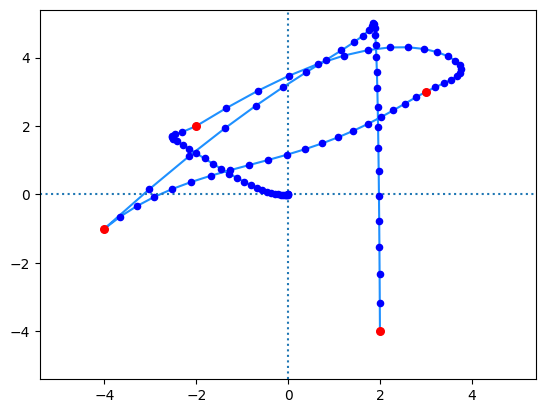

In [ ]:
# E-1 trajectory
plot_trajectory(pos1, np.array([30,50,70,100]))

In [ ]:
# E-2 infeasible
pos2_0,thrusts2_0,res2_0 = drone(T = 101,
                        dt = 0.1,
                        alpha = 1,
                        m = 1,
                        g = 10,
                        p_max = 5,
                        theta_1 = 100*np.pi/180,
                        theta_2 = 180*np.pi/180,
                        J = np.array([50,99,100]),
                        w = np.array([[-2,  2],
                                      [-5, -5],
                                      [-5, -5]]))

Solver Status: infeasible
Optimálne riadenia je možné so spotrebou: inf jednotiek paliva.


In [ ]:
# E-2 optimal – for the adjusted thetas, so it has optimal solution.
pos2_1,thrusts2_1,res2_1 = drone(T = 101,
                        dt = 0.1,
                        alpha = 1,
                        m = 1,
                        g = 10,
                        p_max = 5,
                        theta_1 = 3*np.pi/180,
                        theta_2 = 94*np.pi/180,
                        J = np.array([50,99,100]),
                        w = np.array([[-2,  2],
                                      [-5, -5],
                                      [-5, -5]]))

Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 962.04 jednotiek paliva.


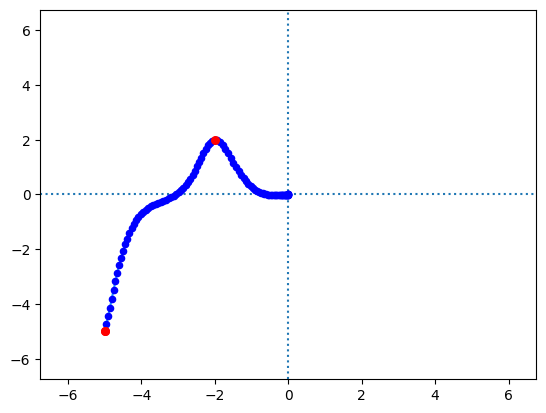

In [ ]:
# E-2 trajectory
plot_trajectory(pos2_1, np.array([50,99,100]))

In [ ]:
# EE-1
pos3,thrusts3,res3 = drone(T = 110,
                        dt = 0.1,
                        alpha = 1,
                        m = 3,
                        g = 10,
                        p_max = 5,
                        theta_1 = 45*np.pi/180,
                        theta_2 = 135*np.pi/180,
                        J = np.array([25,50,75,100]),
                        w = np.array([[4,  4],
                                      [-4, 4],
                                      [-4, -4],
                                      [4, -4]]))

Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 4210.72 jednotiek paliva.


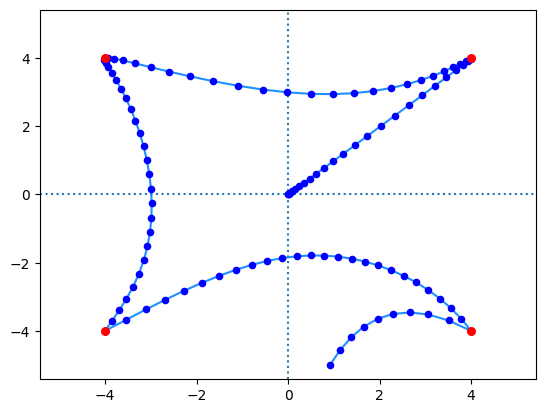

In [ ]:
# EE-1 trajectory
plot_trajectory(pos3, np.array([25,50,75,100]))

In [ ]:
# EE-2
pos4,thrusts4,res4 = drone(T = 71,
                        dt = 0.1,
                        alpha = 1,
                        m = 1,
                        g = 10,
                        p_max = 5,
                        theta_1 = 50,
                        theta_2 = 120,
                        J = np.array([20, 30, 40, 50, 60, 70]),
                        w = np.array([[-1,  1],
                                      [-1, 0],
                                      [0, -1],
                                      [1, 0],
                                      [1, 1],
                                      [0, 0]]),
                        radians = False)

Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 786.95 jednotiek paliva.


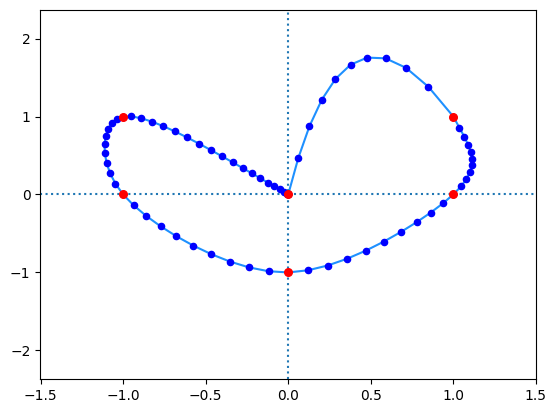

In [ ]:
# EE-2 trajectory
plot_trajectory(pos4, np.array([20, 30, 40, 50, 60, 70]), False)

In [ ]:
# EE-3
pos5,thrusts5,res5 = drone(T = 100,
                        dt = 0.1,
                        alpha = 1,
                        m = 1,
                        g = 10,
                        p_max = 5,
                        theta_1 = 45*np.pi/180,
                        theta_2 = 135*np.pi/180,
                        J = np.array([99]),
                        w = np.array([[1,  1]]))

Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 1315.89 jednotiek paliva.


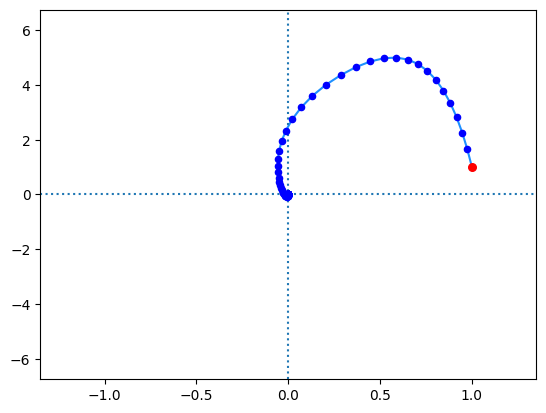

In [ ]:
# EE-3 trajectory
plot_trajectory(pos5, np.array([99]), False)

In [ ]:
# EE-4
pos6,thrusts6,res6 = drone(T = 100,
                        dt = 0.1,
                        alpha = 1,
                        m = 1,
                        g = 10,
                        p_max = 5,
                        theta_1 = 45,
                        theta_2 = 135,
                        J = np.array([13]),
                        w = np.array([[1,  1]]),
                        radians=False)

Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 1207.93 jednotiek paliva.


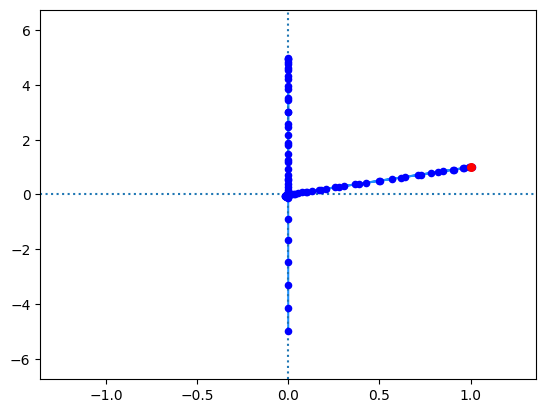

In [ ]:
# EE-4 trajectory
plot_trajectory(pos6, np.array([13]), False)

In [ ]:
# EE-3p_max
pos6p,thrusts6,res6 = drone(T = 100,
                        dt = 0.1,
                        alpha = 1,
                        m = 1,
                        g = 10,
                        p_max = 75,
                        theta_1 = 45,
                        theta_2 = 135,
                        J = np.array([99]),
                        w = np.array([[1,  1]]),
                        radians = False)

Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 1265.0 jednotiek paliva.


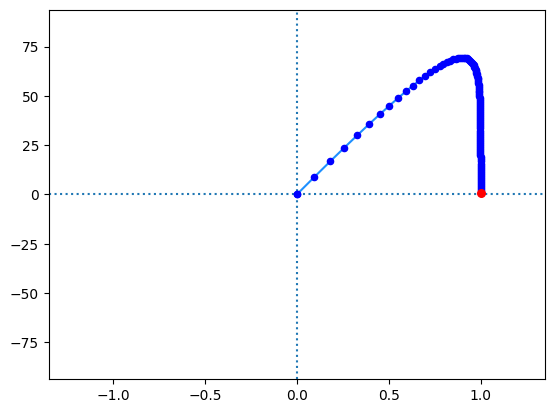

In [ ]:
plot_trajectory(pos6p, np.array([99]), False)

# IV. Simulation in 3D

In [ ]:
w = np.array([
    [0,0,3],
    [0,3,3],
    [3,3,0],
    [3,5,0]])
pos3D,thrusts3D,result = drone(T=41,
      dt=0.25,
      alpha=1,
      m=1,
      dim=3,
      motor_count=4,
      thetas= [0, 90, 180, 270],
      phis = [65, 65, 65, 65],
      J =  np.array([10,20,30,40]),
      w = w,
      p_max = 6,
      u_max=4.5,
      radians = False)

Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 405.92 jednotiek paliva.


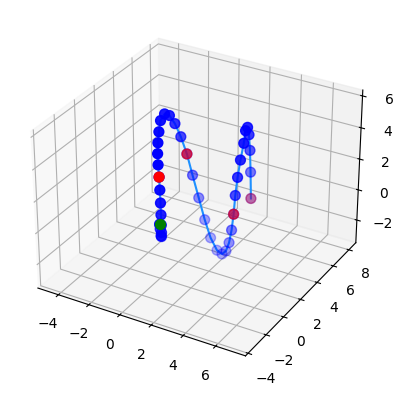

In [ ]:
visualize3D(pos3D, np.array([10,20,30,40]))

Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 408.5 jednotiek paliva.


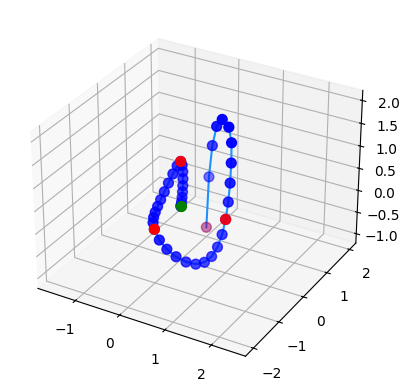

In [ ]:
w = np.array([
    [0,0,1],
    [0,-1,0],
    [1,0,0],
    [0,1,-1]])
pos3D,thrusts3D,result = drone(T=41,
      dt=0.25,
      alpha=1,
      m=1,
      dim=3,
      motor_count=3,
      thetas= [0, 120 , 240],
      phis = [65, 65, 65],
      J =  np.array([10,20,30,40]),
      w = w,
      p_max = 2,
      u_max= 4.5,
      radians = False)
visualize3D(pos3D, np.array([10,20,30,40]))

In [ ]:
w = np.array([
    [-1,0,0]])
pos3D,thrusts3D,result = drone(T=41,
      dt=0.25,
      alpha=1,
      m=1,
      dim=3,
      motor_count=4,
      thetas= [0, 0, 0, 0],
      phis = [0, 0, 90, 90],
      J =  np.array([40]),
      w = w,
      p_max = 6,
      radians = False)
#visualize3D(pos3D, np.array([40]))

Solver Status: infeasible
Optimálne riadenia je možné so spotrebou: inf jednotiek paliva.


Solver Status: optimal
Optimálne riadenia je možné so spotrebou: 369.88 jednotiek paliva.


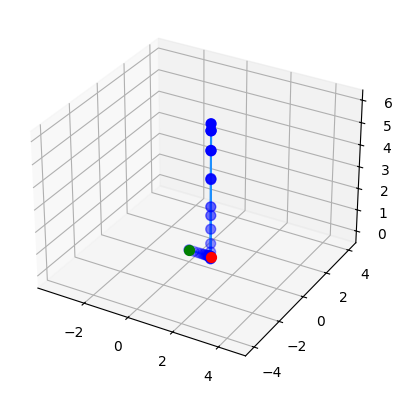

In [ ]:
w = np.array([
    [1,0,0]])
pos3D,thrusts3D,result = drone(T=41,
      dt=0.25,
      alpha=1,
      m=1,
      dim=3,
      motor_count=4,
      thetas= [0, 0, 0, 0],
      phis = [0, 0, 90, 90],
      J =  np.array([40]),
      w = w,
      p_max = 6,
      radians = False)
visualize3D(pos3D, np.array([40]))